In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# For preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler

#For model training and evaluation
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score,cross_validate,GridSearchCV,RandomizedSearchCV


%matplotlib inline

In [2]:
model_dict = {
    'Random Forest': RandomForestRegressor(),
    'SVR' : SVR(),
    'GradientBoosting' : GradientBoostingRegressor(),
    'AdaboostRegressor' : AdaBoostRegressor()
}

In [37]:
param_grid = {

    'Random Forest': {
        'n_estimators': list(np.linspace(start=50, stop=300, num=6).astype(int)),
        'max_depth': list(np.linspace(2, 12, num=6).astype(int)),
        'min_samples_split': list(np.linspace(2, 8, num=8).astype(int)),
        'min_samples_leaf': list(np.linspace(2, 8, num=8).astype(int)),
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma' : ['scale','auto',0.1,0.5]
    },

    'GradientBoosting': {

        'n_estimators': list(np.linspace(start=50, stop=300, num=6).astype(int)),
        'learning_rate': [0.01, 0.1],
        'max_depth': list(np.linspace(2, 12, num=6).astype(int)),
        'min_samples_split': list(np.linspace(2, 10, num=8).astype(int)),
        'min_samples_leaf': list(np.linspace(2, 10, num=8).astype(int)),
    },
    'AdaboostRegressor' : {
        'n_estimators': list(np.linspace(start=50, stop=300, num=6).astype(int)),
        'learning_rate': [0.01, 0.1,0.001,0.2],
        'loss' : ['linear', 'square', 'exponential']

    }
}


In [4]:
def hyperparameter_tuning(X_train, y_train, model_dict, param_dict, grid=True):
    results = []
    best_models = {}
    for model_name, model in model_dict.items():
        if grid:
            search = GridSearchCV(model, param_dict[model_name], scoring='neg_mean_absolute_error', cv=5)
        else:
            search = RandomizedSearchCV(model, param_dict[model_name], scoring='neg_mean_absolute_error', cv=5)

        start_time = time.time()
        search.fit(X_train, y_train)
        end_time = time.time()

        time_taken = end_time - start_time
        print(f" Time taken for training {model_name} is {time_taken} ")
        results.append({
            'model': model_name,
            'best_params': search.best_params_,
            'best_score': -search.best_score_
        })
        best_models[model_name] = search.best_estimator_
    return pd.DataFrame(results), best_models

def evaluate_models(models, X_test, y_test):
    evaluations = {}
    n = X_test.shape[0]  # Number of observations
    k = X_test.shape[1]  # Number of parameters

    for model_name, model in models.items():
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))  # Adjusted R-squared
        evaluations[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Adjusted R2': adj_r2}

    return pd.DataFrame(evaluations).T

In [5]:
X_train = pd.read_csv('/content/X_train_processed.csv')
X_test = pd.read_csv('/content/X_test_processed.csv')
y_train = pd.read_csv('/content/y_train.csv')
y_test = pd.read_csv('/content/y_test.csv')


In [6]:
X_train.head()

,category_baby products,category_baked goods,category_baking,category_beverages,category_canned foods,category_cheese,category_cleaning products,category_condiments and sauces,category_dairy,category_frozen,...,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables,quantity,temperature,unit_price,day_of_month,hour
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,0.243934,1.487798,0.491681,0.635836
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,-0.799070,-0.179331,-0.008474,0.635836
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,-1.128592,-0.642422,1.491990,0.319377
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,1.354878,-0.642422,0.491681,-0.313541
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,0.160577,0.413426,1.491990,0.002918


In [36]:
X_test.head()

,category_baby products,category_baked goods,category_baking,category_beverages,category_canned foods,category_cheese,category_cleaning products,category_condiments and sauces,category_dairy,category_frozen,...,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables,quantity,temperature,unit_price,day_of_month,hour
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.060016,0.848670,0.228189,-1.008784,-0.630000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,-0.994784,-1.383369,-1.008784,-1.262918
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,0.513797,-0.179331,0.491681,0.002918
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,-1.447069,-0.364568,-0.008474,-0.630000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.505349,-0.538280,2.228744,-1.508939,-0.946459


In [38]:
random_result , random_best_models = hyperparameter_tuning(X_train, y_train['estimated_stock_pct'], model_dict, param_grid, grid=False)

 Time taken for training Random Forest is 123.89721822738647 
 Time taken for training SVR is 464.53530526161194 
 Time taken for training GradientBoosting is 103.810063123703 
 Time taken for training AdaboostRegressor is 98.51001167297363 


In [43]:
random_result.to_csv('random_hyper_result.csv')

In [39]:
random_result

,model,best_params,best_score
0,Random Forest,"{'n_estimators': 100, 'min_samples_split': 3, ...",0.222877
1,SVR,"{'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}",0.223178
2,GradientBoosting,"{'n_estimators': 200, 'min_samples_split': 10,...",0.222743
3,AdaboostRegressor,"{'n_estimators': 150, 'loss': 'exponential', '...",0.222630


In [40]:
df_eval = evaluate_models(random_best_models, X_test, y_test['estimated_stock_pct'])

In [41]:
df_eval

,RMSE,MAE,R2,Adjusted R2
Random Forest,0.264011,0.221921,0.000559,-0.012045
SVR,0.264376,0.222136,-0.002203,-0.014842
GradientBoosting,0.264054,0.222014,0.000237,-0.012371
AdaboostRegressor,0.264154,0.222054,-0.000520,-0.013137


In [42]:
df_eval.to_csv('Random_hyper_eval_metric.csv')

# Lets try with stackingg regression.

In [ ]:
level0 = list()
level0.append(('rf', RandomForestRegressor(max_depth=2, min_samples_leaf=2, n_estimators=150)))
level0.append(('svr',SVR(C=10, kernel='linear')))
level0.append(('gb', GradientBoostingRegressor(learning_rate=0.01, max_depth=2, min_samples_leaf=6,
                           min_samples_split=10)))
level0.append(('lr', LinearRegression()))
level0.append(('ridge', Ridge()))
level0.append(('lasso', Lasso()))


# define meta learner model
level1 = RandomForestRegressor(max_depth=2, min_samples_leaf=2, n_estimators=150)

# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

# fit the model on all available data
model.fit(x_tr_trail, y_train['estimated_stock_pct'])

# make a prediction
yhat = model.predict(x_ts_trial)

# evaluate predictions
rmse = np.sqrt(mean_squared_error( y_test['estimated_stock_pct'], yhat))
mae = mean_absolute_error( y_test['estimated_stock_pct'], yhat)
r2 = r2_score( y_test['estimated_stock_pct'], yhat)


print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('r2 :%.3f' % r2)

RMSE: 0.264
MAE: 0.222
r2 :-0.000


# Comparing results from Default Training and hyperparameter tuned.

* __Default Model Training__

In [45]:
default_report = pd.read_csv('/content/Default_report.csv',index_col=0)
default_report

,RMSE,MAE,R2
Random Forest,0.283031,0.235420,-0.148630
SVR,0.276302,0.230163,-0.094661
GradientBoosting,0.264969,0.222582,-0.006704
AdaboostRegressor,0.264153,0.222318,-0.000512


---------------------------------------------------------------------------------------------------------------------

* __Hyperparameter tuned, RandomSearch CV__

In [44]:
hyper_random_report = pd.read_csv('/content/Random_hyper_eval_metric.csv',index_col=0)
hyper_random_report

,RMSE,MAE,R2,Adjusted R2
Random Forest,0.264011,0.221921,0.000559,-0.012045
SVR,0.264376,0.222136,-0.002203,-0.014842
GradientBoosting,0.264054,0.222014,0.000237,-0.012371
AdaboostRegressor,0.264154,0.222054,-0.000520,-0.013137


---------------------------------------------------------------------------------------------------------------------

* __Hyperparameter tuned, RandomSearch CV of important features(RF)__

In [ ]:
hyper_random_report_impfeatures = pd.read_csv('/content/Random_hyper_eval_metric_impfeature.csv',index_col=0)
hyper_random_report_impfeatures

,RMSE,MAE,R2,Adjusted R2
Random Forest,0.263919,0.221926,0.001258,-0.001051
SVR,0.264011,0.221997,0.000564,-0.001746
GradientBoosting,0.264137,0.222150,-0.000393,-0.002706
AdaboostRegressor,0.264213,0.222126,-0.000972,-0.003286


---------------------------------------------------------------------------------------------------------------------

## Insights:
* We can see that R2 was negative for all models in default results. Negative R2 is very bad. In hyperparameter tuned results, especially for important feature dataset, R2 for RF and SVR is positive. Eventhough the overall score is bad but it is improved.
* Also, RMSE and MAE has been reduced a bit for hyperparameter tuned reports. Eventhough MAE is 0.22 which means that the model outputs the fluctuation of 0.22 from average value (0.51) of estimated stock level pct. This means that on average, the model's predictions are off by 44% of the average estimated stock level

* Overall, tuning have improved the model a bit but the results are still BAD. We need more data so that the model learns the pattern better. Since this was only one week's data, monthly data would improve the model.



# RF Importance using best  params

In [8]:
randomcv_result = pd.read_csv('/content/random_hyper_result.csv',index_col=0)
randomcv_result

,model,best_params,best_score
0,Random Forest,"{'n_estimators': 250, 'min_samples_split': 6, ...",0.222700
1,SVR,"{'kernel': 'linear', 'gamma': 'auto', 'C': 0.1}",0.223178
2,GradientBoosting,"{'n_estimators': 50, 'min_samples_split': 10, ...",0.222972


In [25]:
RF_best_params = randomcv_result['best_params'][0]
RF_best_params

"{'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 2}"

In [26]:
import ast

In [27]:
RF_best_params = ast.literal_eval(RF_best_params)

In [29]:
rf_hyper = RandomForestRegressor()
rf_hyper.set_params(**RF_best_params)

RandomForestRegressor(max_depth=2, min_samples_leaf=4, min_samples_split=6,
                      n_estimators=250)

In [33]:
rf_hyper.fit(X_train,y_train)

<ipython-input-33-a71cdd147990>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_hyper.fit(X_train,y_train)


RandomForestRegressor(max_depth=2, min_samples_leaf=4, min_samples_split=6,
                      n_estimators=250)

## Next time save the final model with params as pkl file using joblib

In [34]:
importances = rf_hyper.feature_importances_

# Convert the importances into a DataFrame
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the DataFrame to reveal the most important features
importances_df = importances_df.sort_values(by='Importance', ascending=False)

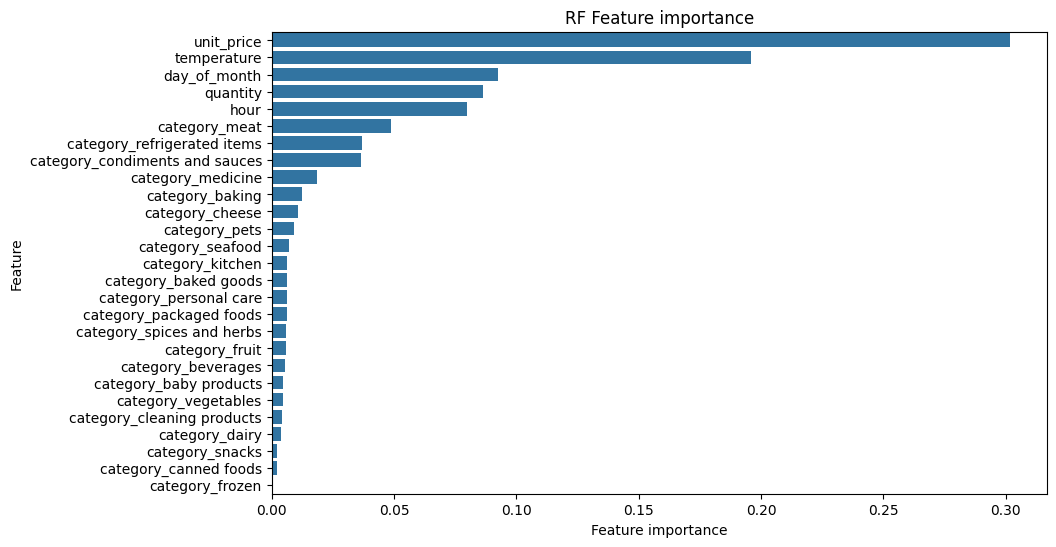

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances_df, orient='h')

plt.xlabel('Feature importance')
plt.title('RF Feature importance')
plt.show()